# Análisis del dataset `Dormir.csv`

- Integrantes:

-`Castro Bryan`

-`Rene Tipan`

Este notebook realiza la limpieza, EDA, pruebas estadísticas y una regresión OLS para investigar factores que afectan la calidad del sueño.

Notas: la columna `Sleep Duration` en el CSV parece expresada en *décimas de hora* (por ejemplo `78` -> 7.8 horas). En la celda de limpieza aplico una transformación condicional (dividir por 10 si el máximo > 24). Si en tu caso los valores ya están en horas, elimina esa transformación.

## Celdas de configuración y carga

En las siguientes celdas importamos bibliotecas, cargamos el CSV y hacemos limpieza básica para dejar el dataset listo para los análisis solicitados.

In [776]:
# Imports básicos y configuración
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [777]:
sns.set(style="whitegrid")
pd.options.display.max_columns = None
pd.options.display.width = 200


path = './Dormir.csv'
df = pd.read_csv(path, sep=';')
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,61,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,62,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,62,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,59,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,59,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [778]:
# Revisar info y estadísticas básicas
print(df.info())
print(df.describe(include='all'))

# Renombrar columnas para facilitar el análisis
df = df.rename(columns={
    'Person ID':'PersonID',
    'Sleep Duration':'SleepDuration',
    'Quality of Sleep':'Quality',
    'Physical Activity Level':'PhysicalActivity',
    'Stress Level':'Stress',
    'BMI Category':'BMI_Category',
    'Blood Pressure':'BloodPressure',
    'Heart Rate':'HeartRate',
    'Daily Steps':'DailySteps',
    'Sleep Disorder':'SleepDisorder'
})

df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Person ID                374 non-null    int64 
 1   Gender                   374 non-null    object
 2   Age                      374 non-null    int64 
 3   Occupation               374 non-null    object
 4   Sleep Duration           374 non-null    int64 
 5   Quality of Sleep         374 non-null    int64 
 6   Physical Activity Level  374 non-null    int64 
 7   Stress Level             374 non-null    int64 
 8   BMI Category             374 non-null    object
 9   Blood Pressure           374 non-null    object
 10  Heart Rate               374 non-null    int64 
 11  Daily Steps              374 non-null    int64 
 12  Sleep Disorder           155 non-null    object
dtypes: int64(8), object(5)
memory usage: 38.1+ KB
None
         Person ID Gender         Age Occupa

,PersonID,Gender,Age,Occupation,SleepDuration,Quality,PhysicalActivity,Stress,BMI_Category,BloodPressure,HeartRate,DailySteps,SleepDisorder
0,1,Male,27,Software Engineer,61,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,62,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,62,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,59,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,59,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [779]:
df.isna().sum()

PersonID              0
Gender                0
Age                   0
Occupation            0
SleepDuration         0
Quality               0
PhysicalActivity      0
Stress                0
BMI_Category          0
BloodPressure         0
HeartRate             0
DailySteps            0
SleepDisorder       219
dtype: int64

In [780]:
df["Occupation"].unique()

array(['Software Engineer', 'Doctor', 'Sales Representative', 'Teacher',
       'Nurse', 'Engineer', 'Accountant', 'Scientist', 'Lawyer',
       'Salesperson', 'Manager'], dtype=object)

In [781]:

df['BMI_Category'] = df['BMI_Category'].astype(str).str.strip()
df['Gender'] = df['Gender'].astype(str).str.strip()
# Extraer sistólica/diastólica
bp = df['BloodPressure'].astype(str).str.split('/', expand=True)
df['Systolic'] = pd.to_numeric(bp[0], errors='coerce')
df['Diastolic'] = pd.to_numeric(bp[1], errors='coerce')
# SleepDuration transformación: dividir por 10 si el máximo > 24 (pista de décimas de hora)
df['SleepDuration'] = pd.to_numeric(df['SleepDuration'], errors='coerce')
if df['SleepDuration'].max() > 24:
    df['SleepDuration'] = df['SleepDuration'] / 10.0
# Cast numéricas
df['Quality'] = pd.to_numeric(df['Quality'], errors='coerce')
df['PhysicalActivity'] = pd.to_numeric(df['PhysicalActivity'], errors='coerce')
df['Stress'] = pd.to_numeric(df['Stress'], errors='coerce')
df['DailySteps'] = pd.to_numeric(df['DailySteps'], errors='coerce')
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['HeartRate'] = pd.to_numeric(df['HeartRate'], errors='coerce')



df.head()

,PersonID,Gender,Age,Occupation,SleepDuration,Quality,PhysicalActivity,Stress,BMI_Category,BloodPressure,HeartRate,DailySteps,SleepDisorder,Systolic,Diastolic
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN,126,83
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN,125,80
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN,125,80
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,140,90
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea,140,90


In [782]:
# Codificación de variables categóricas
# Codificación del campo 'Occupation' con ordinal
le = LabelEncoder()


In [783]:
# Limpeza de datos

df.drop(columns=['PersonID', "BloodPressure"], inplace=True)
df.head()

,Gender,Age,Occupation,SleepDuration,Quality,PhysicalActivity,Stress,BMI_Category,HeartRate,DailySteps,SleepDisorder,Systolic,Diastolic
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,NaN,126,83
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,NaN,125,80
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,NaN,125,80
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


## Pregunta 1: ¿Quiénes tienen peor calidad del sueño, hombres o mujeres?

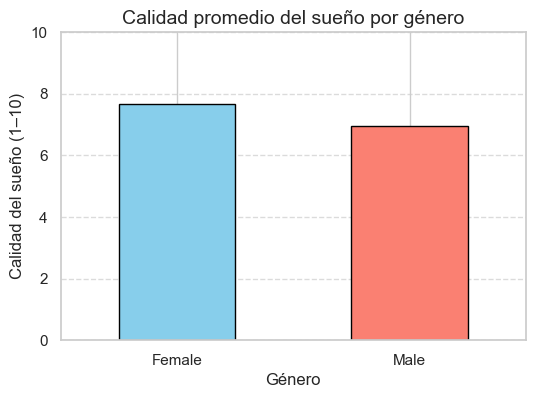

Gender
Female    7.664865
Male      6.968254
Name: Quality, dtype: float64


In [784]:
# Comparación por género
plt.figure(figsize=(6,4))
promedio_calidad = df.groupby("Gender")["Quality"].mean()

promedio_calidad.plot(kind="bar", color=["skyblue", "salmon"], edgecolor="black")

plt.title("Calidad promedio del sueño por género", fontsize=14)
plt.xlabel("Género")
plt.ylabel("Calidad del sueño (1–10)")
plt.xticks(rotation=0)
plt.ylim(0, 10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

print(promedio_calidad)


Los `Hombres` presentan una peor calidad de sueño con un promedio de calidad de sueño de `6.96`

## Pregunta 2: ¿Existe relación entre la calidad del sueño y la profesión?

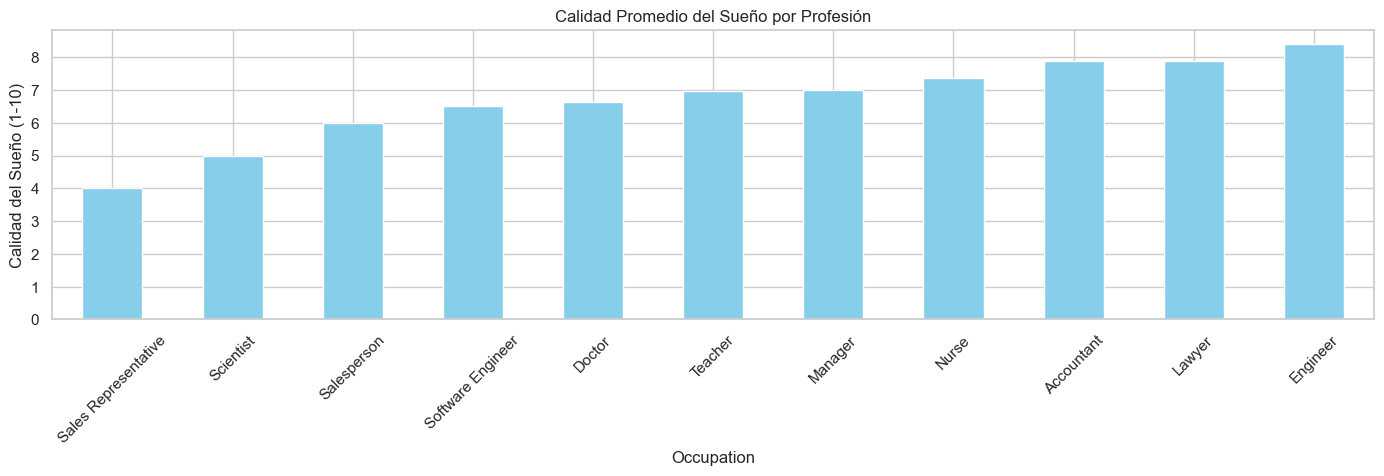

In [785]:
# Agrupar por ocupación para calcular medias (usado en el segundo subplot)
occupation_sleep = df.groupby('Occupation')['Quality'].agg(['mean','std','count']).sort_values('mean')

plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 2)
occupation_sleep['mean'].plot(kind='bar', color='skyblue')
plt.title('Calidad Promedio del Sueño por Profesión')
plt.ylabel('Calidad del Sueño (1-10)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Si existe una relacion entre la calidad de sueño y la profesion que mantienen las personas, dado que tenemos una peor calidad de sueño en las personas que son Representantes de ventas

## Pregunta 3: ¿La actividad física afecta al sueño?
Analizaremos correlaciones y mostramos gráficos de dispersión.

<Axes: xlabel='PhysicalActivity', ylabel='Quality'>

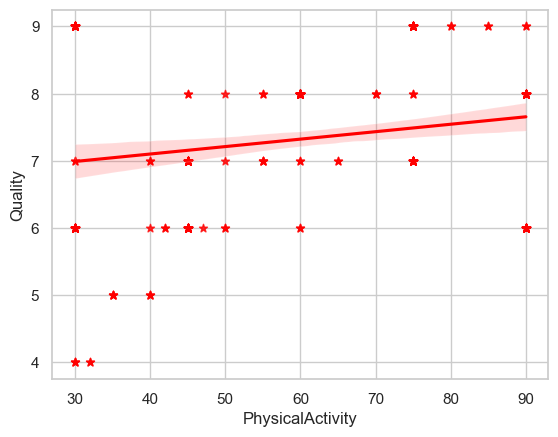

In [786]:
sns.regplot(x="PhysicalActivity", y="Quality", data=df, marker="*", color="red")


<Axes: xlabel='PhysicalActivity', ylabel='SleepDuration'>

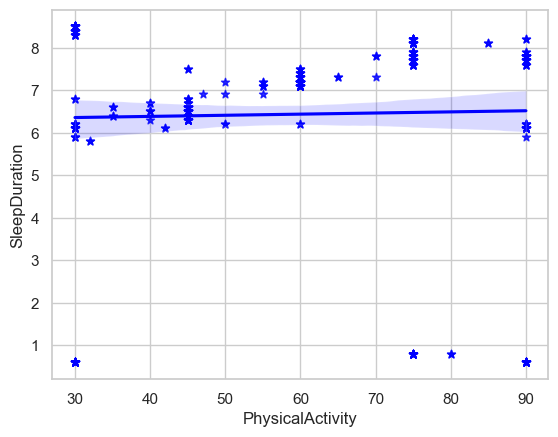

In [787]:
sns.regplot(x="PhysicalActivity", y="SleepDuration", data=df, marker="*", color="blue")

La línea de regresión de color azul es prácticamente plana (horizontal). Esto significa que un aumento en la Actividad Física no se traduce en un aumento ni en una disminución de la Duración del Sueño promedio.

Los puntos de datos están muy dispersos verticalmente. La Duración del Sueño varía enormemente para cualquier nivel de Actividad Física, lo que indica que la duración está determinada por otros factores y no por la cantidad de ejercicio.
La línea de regresión de calidad de sueño tiene una pendiente positiva suave. Esto sugiere que, a mayor Actividad Física, la Calidad reportada tiende a ser ligeramente mejor.

## Preguntas 4: ¿Qué profesión presenta peor calidad de sueño?

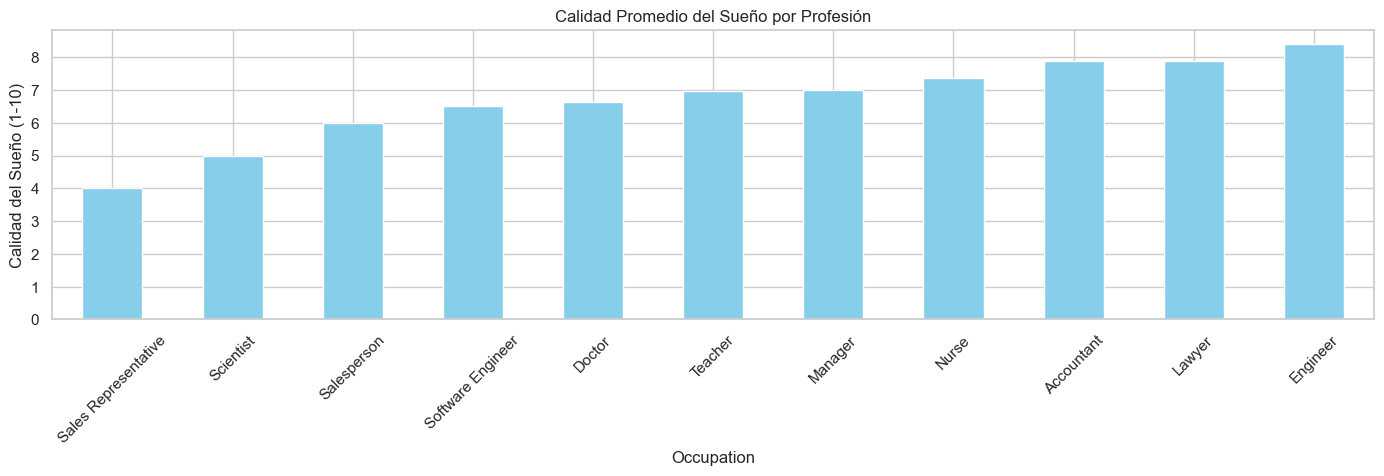

In [788]:
# Agrupar por ocupación para calcular medias (usado en el segundo subplot)
occupation_sleep = df.groupby('Occupation')['Quality'].agg(['mean','std','count']).sort_values('mean')

plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 2)
occupation_sleep['mean'].plot(kind='bar', color='skyblue')
plt.title('Calidad Promedio del Sueño por Profesión')
plt.ylabel('Calidad del Sueño (1-10)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


La profesion que presenta peor calidad de sueño es `Sales Representative`

# Pregunta 5: - ¿Cuál profesión tienen a las personas con el mayor nivel de estrés y el mayor índice de masa corporal

In [789]:
df["BMI_Category"] = df["BMI_Category"].map({
    'Overweight': 0,
    'Normal': 1,
    'Obese': 2,
    'Normal Weight': 3,
});

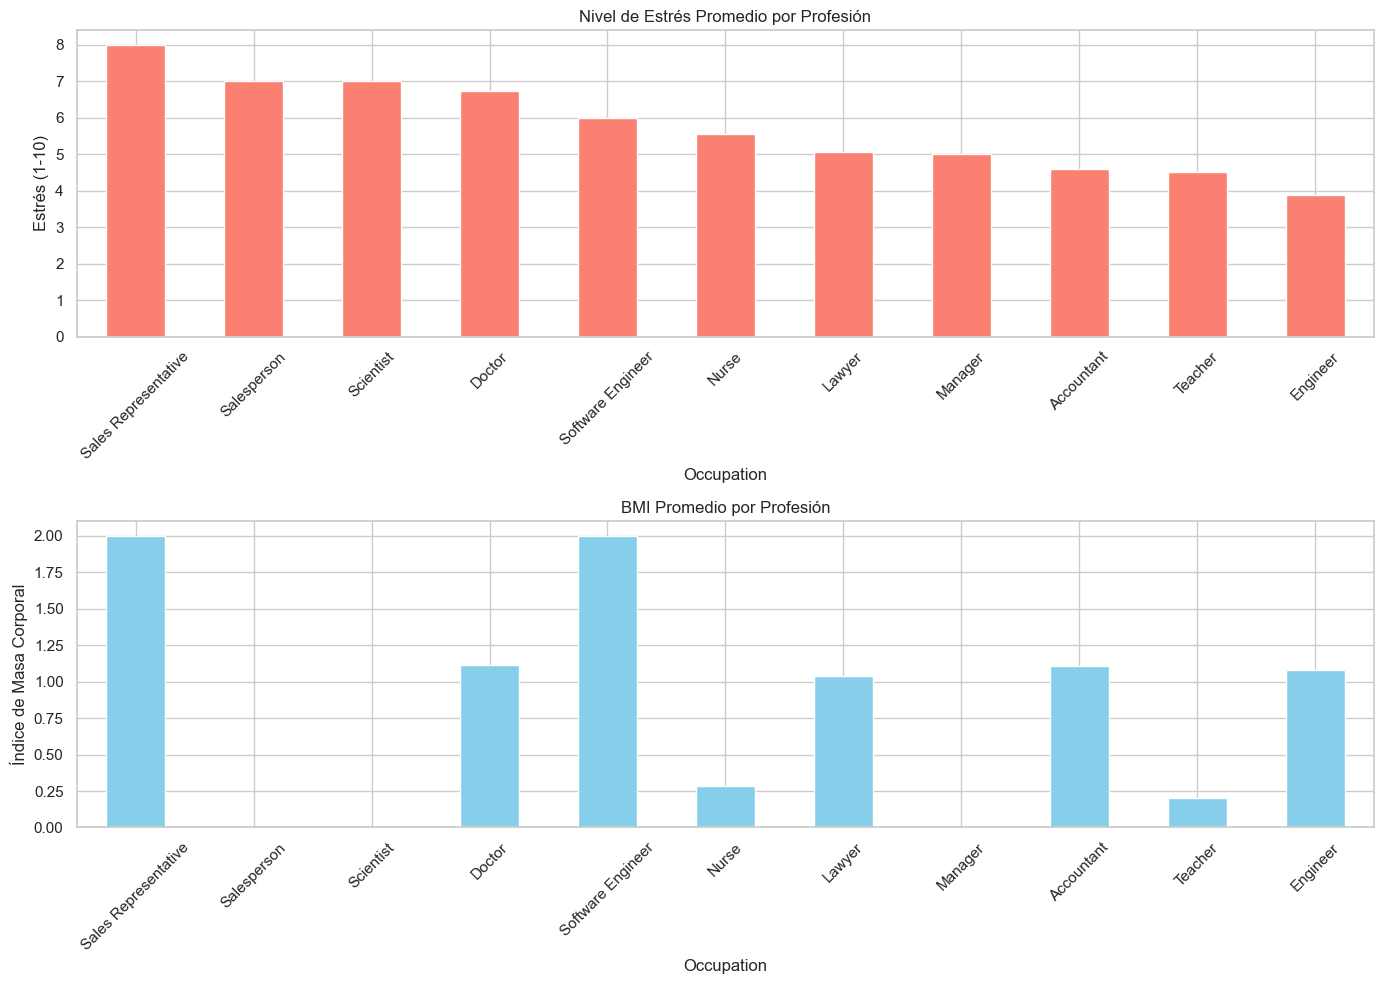

In [790]:
occupation_stats = df.groupby('Occupation')[['Stress','BMI_Category']].mean().sort_values('Stress', ascending=False)

plt.figure(figsize=(14, 10))

# Subplot 1: Nivel de Estrés promedio
plt.subplot(2, 1, 1)
occupation_stats['Stress'].plot(kind='bar', color='salmon')
plt.title('Nivel de Estrés Promedio por Profesión')
plt.ylabel('Estrés (1-10)')
plt.xticks(rotation=45)

# Subplot 2: Índice de Masa Corporal promedio
plt.subplot(2, 1, 2)
occupation_stats['BMI_Category'].plot(kind='bar', color='skyblue')
plt.title('BMI Promedio por Profesión')
plt.ylabel('Índice de Masa Corporal')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Las personas que ejercen la profesion de `Sales Representative` tienen un promedio muy alto en cuanto al nivel de estres, y las personas que son `Salesperson`, `scientist` y `Manger` son las que tiene  mayor Indice de masa corporal

## Pregunta 6: ¿En qué rango de edades se encuentran la mayor cantidad de trastornos del sueño?

C:\Users\Dev\AppData\Local\Temp\ipykernel_5324\2748013580.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disorder_by_age = df[df['HasDisorder']].groupby('AgeBin').size().sort_values(ascending=False)


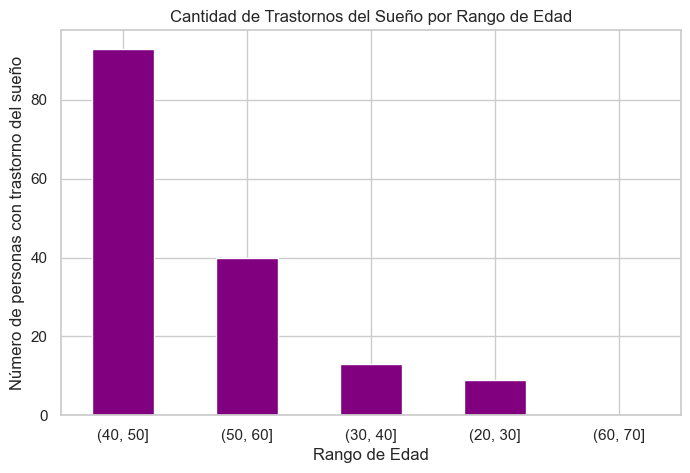

In [791]:
df['HasDisorder'] = df['SleepDisorder'].fillna('None').apply(lambda x: False if str(x).strip().lower()=='none' else True)
age_bins = [20,30,40,50,60,70]
df['AgeBin'] = pd.cut(df['Age'], bins=age_bins)
disorder_by_age = df[df['HasDisorder']].groupby('AgeBin').size().sort_values(ascending=False)
plt.figure(figsize=(8,5))
disorder_by_age.plot(kind='bar', color='purple')
plt.title('Cantidad de Trastornos del Sueño por Rango de Edad')
plt.xlabel('Rango de Edad')
plt.ylabel('Número de personas con trastorno del sueño')
plt.xticks(rotation=0)
plt.show()

In [792]:

disorder_by_age

AgeBin
(40, 50]    93
(50, 60]    40
(30, 40]    13
(20, 30]     9
(60, 70]     0
dtype: int64

La mayor cantidad de trastornos del sueño se encuentra entre `40` y `50` años

## Pregunta 7: La cantidad de pasos al día, ¿afecta la calidad del sueño? ¿al índice de masa corporal?

<Axes: xlabel='DailySteps', ylabel='Quality'>

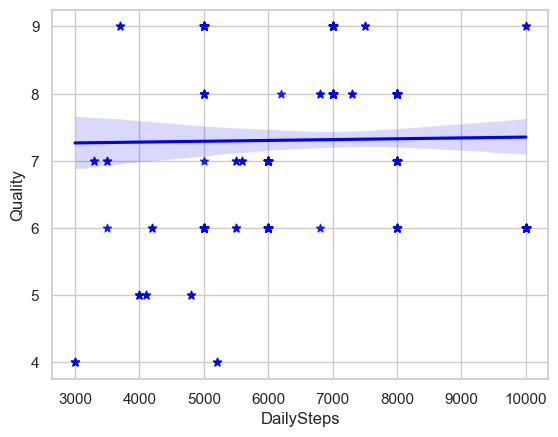

In [793]:
sns.regplot(x="DailySteps", y="Quality", data=df, marker="*", color="blue")


<Axes: xlabel='DailySteps', ylabel='BMI_Category'>

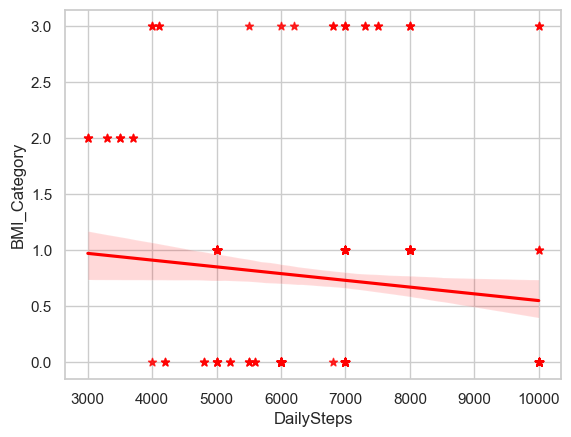

In [794]:
sns.regplot(x="DailySteps", y="BMI_Category", data=df, marker="*", color="red")


In [795]:
corr_sleep = df['DailySteps'].corr(df['Quality'])
corr_bmi = df['DailySteps'].corr(df['BMI_Category'])
print("Correlación pasos diarios - calidad del sueño:", corr_sleep)
print("Correlación pasos diarios - indice de masa corporal:", corr_bmi)

Correlación pasos diarios - calidad del sueño: 0.01679141492471604
Correlación pasos diarios - indice de masa corporal: -0.12760054053092842


La cantidad de pasos no tiene nada que ver con la `calidad de sueño` ni el `indice de masa corporal`

## Regresión OLS para determinar modelo de Quality

Ajustaremos un OLS usando variables relevantes (SleepDuration, PhysicalActivity, Stress, Age, DailySteps y dummies para género/ocupación/BMI). Luego calcularemos VIF y reduciremos el modelo por p-values.

In [796]:
df["SleepDisorder"].unique()

array([nan, 'Sleep Apnea', 'Insomnia'], dtype=object)

In [797]:


df["Occupation"] = df["Occupation"].map(
    {'Software Engineer':1,
      'Doctor':2,
      'Sales Representative':3,
      'Teacher':4,
      'Nurse':5,
      'Engineer':6,
      'Accountant':7,
      'Scientist':8,
      'Lawyer':9,
      'Salesperson':10,
      'Manger':11}).fillna(-1).astype(int)

df['SleepDisorder'] = df["SleepDisorder"].map(
    {'Sleep Apnea':1,
      'Insomnia':2}).fillna(0).astype(int)
df['Gender'] = le.fit_transform(df['Gender'])
df.head()

,Gender,Age,Occupation,SleepDuration,Quality,PhysicalActivity,Stress,BMI_Category,HeartRate,DailySteps,SleepDisorder,Systolic,Diastolic,HasDisorder,AgeBin
0,1,27,1,6.1,6,42,6,0,77,4200,0,126,83,False,"(20, 30]"
1,1,28,2,6.2,6,60,8,1,75,10000,0,125,80,False,"(20, 30]"
2,1,28,2,6.2,6,60,8,1,75,10000,0,125,80,False,"(20, 30]"
3,1,28,3,5.9,4,30,8,2,85,3000,1,140,90,True,"(20, 30]"
4,1,28,3,5.9,4,30,8,2,85,3000,1,140,90,True,"(20, 30]"


In [798]:
df.drop(columns=['HasDisorder', 'AgeBin', 'DailySteps', 'Systolic', 'Diastolic'], inplace=True)

x = df.drop(["Quality"], axis=1)
y = df[["Quality"]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
regresion = LinearRegression()
regresion.fit(x_train, y_train)
y_pred = regresion.predict(x_test)
print(regresion.intercept_)
print(regresion.coef_)
regresion.score(x_train, y_train)
print(x)

[10.51100303]
[[ 0.35953799  0.04759923  0.00961713 -0.00594873  0.00717483 -0.44091579
   0.1737835  -0.04821039 -0.33998007]]
     Gender  Age  Occupation  SleepDuration  PhysicalActivity  Stress  BMI_Category  HeartRate  SleepDisorder
0         1   27           1            6.1                42       6             0         77              0
1         1   28           2            6.2                60       8             1         75              0
2         1   28           2            6.2                60       8             1         75              0
3         1   28           3            5.9                30       8             2         85              1
4         1   28           3            5.9                30       8             2         85              1
..      ...  ...         ...            ...               ...     ...           ...        ...            ...
369       0   59           5            8.1                75       3             0         68        

In [799]:
# Preparar datos para OLS

data = pd.DataFrame(x_train, columns=x_train.columns)
data["Quality"] = y_train.values
indep_vars = " + ".join(data.columns.drop("Quality"))
formula = f"Quality ~ {indep_vars}"
regre = smf.ols(formula=formula, data=data).fit()
print(regre.summary())

                            OLS Regression Results                            
Dep. Variable:                Quality   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     442.4
Date:                Thu, 16 Oct 2025   Prob (F-statistic):          2.57e-163
Time:                        09:29:32   Log-Likelihood:                -77.201
No. Observations:                 299   AIC:                             174.4
Df Residuals:                     289   BIC:                             211.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           10.5110      0.457  

$ Quality = 9.14 + 0.37 * Gender + 0.055 * Age  - 0.05 * Occupation - 0.011 * PhysicalActivity - 0.4963 * Stress -0.25 * BmiCategory + 0.12 * SleepDiscorder$

In [800]:
df.head()

,Gender,Age,Occupation,SleepDuration,Quality,PhysicalActivity,Stress,BMI_Category,HeartRate,SleepDisorder
0,1,27,1,6.1,6,42,6,0,77,0
1,1,28,2,6.2,6,60,8,1,75,0
2,1,28,2,6.2,6,60,8,1,75,0
3,1,28,3,5.9,4,30,8,2,85,1
4,1,28,3,5.9,4,30,8,2,85,1


In [802]:
print(x_train.columns.tolist())
print("Número de características que espera el modelo:", regresion.n_features_in_)
print("Columnas del dataset original:", x.columns.tolist())



['Gender', 'Age', 'Occupation', 'SleepDuration', 'PhysicalActivity', 'Stress', 'BMI_Category', 'HeartRate', 'SleepDisorder']
Número de características que espera el modelo: 9
Columnas del dataset original: ['Gender', 'Age', 'Occupation', 'SleepDuration', 'PhysicalActivity', 'Stress', 'BMI_Category', 'HeartRate', 'SleepDisorder']


- Género: Hombre - 1
- Edad: 21
- Occupation: Enginner - 6
- Sleep Duration : 10
- PhysicalActivity: 70
- Stress: 8
- BMI_Category: 3
- HeartRate: 60
- SleepDisorder: NO - 0

In [803]:
predicciones = regresion.predict([[1, 21, 6, 10, 70, 8, 3, 60, 0]])
print(r"La calidad de sueño es: ", predicciones)


La calidad de sueño es:  [[6.47197918]]


c:\Users\Dev\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


- Género: Mujer - 0
- Edad: 55
- Occupation: Nurse - 5
- Sleep Duration : 12
- PhysicalActivity: 55
- Stress: 5
- BMI_Category: Normal-1
- HeartRate: 60
- SleepDisorder: NO - 0

In [804]:
predicciones = regresion.predict([[0, 55, 5, 12, 55, 5, 1, 60, 0]])
print(r"La calidad de sueño es: ", predicciones)

La calidad de sueño es:  [[8.57685825]]


c:\Users\Dev\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
